<a href="https://colab.research.google.com/github/djalil21/sentiment-analysis-algerian-dialect/blob/master/DZ_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and data

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/prepocess.csv')

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.text=df.text.astype(str)

In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [ ]:
df.shape

(6181, 2)

In [ ]:
df.head()

,sentiment,text
0,positive,ربراب إنها الرجل عمل قو ج رسپكت ال أكثر، ل أنا...
1,positive,مدر ال ابيلس سس پاس التابع ڤولورس ربراب ن1 هاد...
2,negative,له جوه صحاح.
3,negative,دخل كي كره سطيف ماش كي حب سياس .
4,negative,حن بن منوع


<Axes: ylabel='sentiment'>

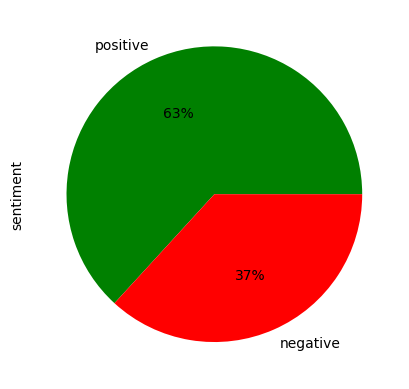

In [ ]:
import matplotlib.pyplot as plt

df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green", "red"])


In [ ]:
df["sentiment"]=df["sentiment"].map({"negative":0,"positive":1})

#WORD2vec

In [ ]:
text = df['text'].apply(lambda x: x.split())

In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 128

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()
print(cores)

2


In [ ]:
# Defining the model and training it.
word2vec_model = Word2Vec(text,
                 vector_size=Embedding_dimensions,
                 workers=cores-1,
                 min_count=1)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 11653


In [ ]:
word2vec_model.train(text, total_examples= len(text),epochs=40)

(2021690, 2332440)

# LSTM

In [ ]:
X_data, y_data = np.array(df['text']), np.array(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 0.2)

In [ ]:
"""
from gensim.models import Word2Vec

Embedding_dimensions = 300

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
"""

In [ ]:
"""
import multiprocessing

cores = multiprocessing.cpu_count()
print(cores)
"""

In [ ]:
"""
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=cores-1,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))
"""

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_length = 60000
input_length = 60

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

In [ ]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")

    return model

In [ ]:
training_model = getModel()
training_model.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(classification_report(y_test, y_pred))
print("DS1 BiLSTM acc ",accuracy_score(y_test, y_pred))

In [ ]:
import pickle

In [ ]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")

# Machine learning

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print("DS1 svm acc ",accuracy_score(y_test, pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print("DS1 RandomForestClassifier acc ",accuracy_score(y_test, pred))

logreg = LogisticRegression()
clf = LogisticRegression()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print("DS1 LogisticRegression acc ",accuracy_score(y_test, pred))

clf = GaussianNB()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print("DS1 GaussianNB acc ",accuracy_score(y_test, pred))

clf = BernoulliNB()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print("DS1 BernoulliNB acc ",accuracy_score(y_test, pred))